# XGBoost regression with hyperparameter tuning by GPyOpt
Reference : <br>
http://krasserm.github.io/2018/03/21/bayesian-optimization/ <br>
https://xgboost.readthedocs.io/en/latest/parameter.html

### Import library and dataset

In [1]:
%matplotlib inline
%pylab inline  
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost
import xgboost as xgb

# Cross validation
from sklearn.model_selection import (KFold, ShuffleSplit)
from sklearn.metrics import mean_squared_error, r2_score

#GPy
import GPy, GPyOpt
from GPyOpt.methods import BayesianOptimization

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load dataset
df = pd.read_csv('glass.csv')
print(df.shape)
df.head()

(214, 11)


,Id number,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type of glass
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
df_test = df.drop(df.columns[[0, 10]], axis=1)
print(df_test.shape)
df_test.head()

(214, 9)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [4]:
X = df_test.iloc[:, 1:]
y = df_test.iloc[:, :1]

In [5]:
print(X.shape)
X.head()

(214, 8)


,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [6]:
print(y.shape)
y.head()

(214, 1)


,RI
0,1.52101
1,1.51761
2,1.51618
3,1.51766
4,1.51742


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(171, 8) (43, 8) (171, 1) (43, 1)


### Default

In [8]:
xgr = xgb.XGBRegressor()
xgr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [9]:
pred_xgr = xgr.predict(X_test)
R2_xgr = r2_score(pred_xgr, y_test)
print('R2 = ', R2_xgr)

R2 =  0.5115816779953148


### Hyperparameter tuning using GPyOpt

In [10]:
# GPyOpt for XGBoost regression

bounds_xgr = [
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
    {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
    {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
    {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)},
    {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}
]

# Optimization objective function

def rmse_xgr(*args):
    params = args[0]
    
    xgr = xgb.XGBRegressor(learning_rate = params[0][0],
                           gamma = int(params[0][1]),
                           max_depth = int(params[0][2]),
                           n_estimators = int(params[0][3]),
                           min_child_weight = params[0][4],
                           bootstrap = True,
                           random_state = 0,
                           silent = True)
                
    xgr.fit(X_train, y_train)
    
    pred_xgr = xgr.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(pred_xgr, y_test))
    
    return RMSE

In [11]:
%%time

optimizer = BayesianOptimization(f = rmse_xgr, domain = bounds_xgr)
optimizer.run_optimization(max_iter = 50)

Wall time: 16.2 s


In [12]:
optimizer.x_opt

array([1.58815584e-01, 3.29003909e-01, 1.00000000e+00, 3.00000000e+02,
       1.00000000e+00])

In [13]:
xgr_best = xgb.XGBRegressor(learning_rate = optimizer.x_opt[0],
                            gamma = int(optimizer.x_opt[1]),
                            max_depth = int(optimizer.x_opt[2]),
                            n_estimators = int(optimizer.x_opt[3]),
                            min_child_weight = optimizer.x_opt[4],
                            bootstrap = True,
                            random_state = 0,
                            silent = True)

xgr_best.fit(X_train, y_train)
y_pred_xgr = xgr_best.predict(X_test)

print('R2 = ', '{:.4}'.format(r2_score(y_pred_xgr, y_test)))

R2 =  0.8675


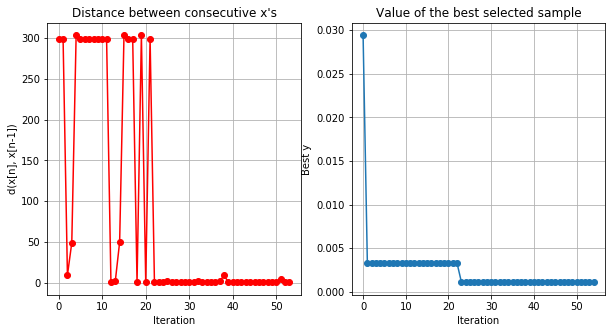

In [14]:
optimizer.plot_convergence()

### Check model performance by CV

R2 =   0.9182


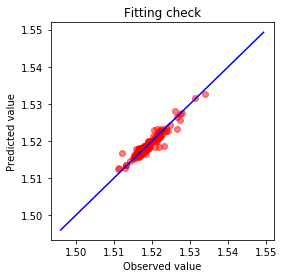

In [15]:
# Use all data
X_train, y_train = X, y

xgr_best = xgb.XGBRegressor(learning_rate = optimizer.x_opt[0],
                            gamma = int(optimizer.x_opt[1]),
                            max_depth = int(optimizer.x_opt[2]),
                            n_estimators = int(optimizer.x_opt[3]),
                            min_child_weight = optimizer.x_opt[4],
                            bootstrap = True,
                            random_state = 0,
                            silent = True)

xgr_best.fit(X_train, y_train)
y_pred = xgr_best.predict(X_train)

print('R2 = ', ' {:.4}'.format(r2_score(y, y_pred)))

plt.figure(figsize = [4, 4])
slp_1_begin = 0.99 * y.min()
slp_1_end   = 1.01 * y.max()

plt.scatter(y, y_pred, c = 'r', alpha = 0.5)
plt.plot([slp_1_begin, slp_1_end], [slp_1_begin, slp_1_end], c = 'b')
plt.title('Fitting check')
plt.xlabel('Observed value')
plt.ylabel('Predicted value')
plt.show()

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import (KFold, ShuffleSplit)
split_num = 5

cv_KF = KFold(n_splits = split_num, shuffle = True, random_state = 0)

print('Check best model perfromance in the folds')
for train_index, test_index in cv_KF.split(X):
    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]
    y_pred = xgr_best.predict(X_test)
    R2_reg = r2_score(y_test, y_pred)
    print(' {:.4}'.format(R2_reg))

Check best model perfromance in the folds
 0.9674
 0.9271
 0.802
 0.8999
 0.9319
